In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
# Activation functions
def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(A):
  return A * (1 - A)

def relu(x):
  return np.maximum(0,x)

def relu_derivative(x):
  return (x > 0).astype(float)

def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return 1 - np.tanh(x)**2

def softmax(Z):
  expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # to prevent overflow
  return expZ / np.sum(expZ, axis=0, keepdims=True)

In [3]:
# Initialize parameters
def initialize_parameters(layer_sizes):
  parameters = {}
  num_of_layers = len(layer_sizes)

  for i in range(1, num_of_layers):
    parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * np.sqrt(2 / layer_sizes[i-1])
    parameters[f'b{i}'] = np.zeros((layer_sizes[i], 1))

  return parameters

# Forward Propogation
def forward_propagation(X, parameters, activations):
  A = X
  caches = []
  num_layers = len(activations)

  for i in range(1, num_layers + 1):
    W = parameters[f'W{i}']
    b = parameters[f'b{i}']
    Z = np.dot(W,A) + b

    if(activations[i-1] == "sigmoid"):
      A = sigmoid(Z)
    elif(activations[i-1] == "relu"):
      A = relu(Z)
    elif(activations[i-1] == "tanh"):
      A = tanh(Z)
    elif(activations[i-1] == "softmax"):
      A = softmax(Z)

    caches.append({"Z":Z, "A":A, "W":W, "b": b})

  return A, caches

# Loss compute
def compute_loss(y,A):
  m = y.shape[1]
  loss = -np.sum(y*np.log(A))/m
  return loss


# Back propogation
def back_propagation(X, y, caches, activations):
  grads = {}
  gradient_magnitudes = {}  # To store gradient magnitudes for each layer
  m = X.shape[1]
  num_layers = len(caches)

  # Computing gradients for the output layer
  A_last = caches[-1]["A"]
  dA = A_last - y

  for i in reversed(range(num_layers)):
    Z, A, W, b = caches[i]["Z"], caches[i]["A"], caches[i]["W"], caches[i]["b"]
    if(activations[i] == "sigmoid"):
      dZ = dA * sigmoid_derivative(A)
    elif(activations[i] == "relu"):
      dZ = dA * relu_derivative(A)
    elif(activations[i] == "tanh"):
      dZ = dA * tanh_derivative(A)
    elif(activations[i] == "softmax"):
      dZ = dA

    dW = np.dot(dZ, caches[i-1]["A"].T) / m if i > 0 else np.dot(dZ, X.T)/m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA = np.dot(W.T, dZ) if i > 0 else None

    grads[f'dW{i+1}'] = dW
    grads[f'db{i+1}'] = db

    # Compute gradient magnitude for the current layer
    gradient_magnitudes[f'layer{i+1}'] = np.linalg.norm(dW)  # Use Frobenius norm for dW

  return grads, gradient_magnitudes

# Update parameters
def update_parameters(parameters, grads, learning_rate):
  num_layers = len(parameters) // 2

  for i in range(1,num_layers + 1):

    # print(f"Layer {i}: W{i} shape {parameters[f'W{i}'].shape}, dW{i} shape {grads[f'dW{i}'].shape}")  # Debugging
    # print(f"Layer {i}: b{i} shape {parameters[f'b{i}'].shape}, db{i} shape {grads[f'db{i}'].shape}")  # Debugging

    #grads[f'dW{i}'] = grads[f'dW{i}'].T
    parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}']
    parameters[f'b{i}'] -= learning_rate * grads[f'db{i}']

  return parameters

# Compute accuracy
def compute_accuracy(y_true, A_pred):
  y_pred = np.argmax(A_pred, axis=0)
  y_true_labels = np.argmax(y_true, axis=0)
  accuracy = np.mean(y_pred == y_true_labels)*100  # Accuracy in percentage
  return accuracy

# Train Neural Network
def train_neural_network(X_train, y_train, layer_sizes, activations, num_epochs=100, learning_rate=0.01):
  loss_history = []
  accuracy_history = []
  parameters = initialize_parameters(layer_sizes)
  gradient_magnitudes_history = {f'layer{i+1}': [] for i in range(len(layer_sizes) - 1)}  # To store gradient magnitudes for each layer

  for epoch in range(num_epochs):
    # Forward propogation
    A, caches = forward_propagation(X_train, parameters, activations)

    # Compute loss
    loss = compute_loss(y_train, A)
    loss_history.append(loss)

    # Compute accuracy
    accuracy = compute_accuracy(y_train, A)
    accuracy_history.append(accuracy)

    # Backward propagation
    grads, gradient_magnitudes = back_propagation(X_train, y_train, caches, activations)

    # Update parameters
    parameters = update_parameters(parameters, grads, learning_rate)

    # Store gradient magnitudes for each layer
    for layer in gradient_magnitudes:
        gradient_magnitudes_history[layer].append(gradient_magnitudes[layer])

    # Print loss and accuracy every 10 epochs
    if(epoch % 10 == 0):
      print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

  # Plot loss and accuracy curves
  plt.figure(figsize=(12,5))

  # Loss curve
  plt.subplot(1, 2, 1)
  plt.plot(range(num_epochs), loss_history, label="Loss", color="red")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend()

  # Accuracy Curve
  plt.subplot(1, 2, 2)
  plt.plot(range(num_epochs), accuracy_history, label="Accuracy", color="blue")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy (%)")
  plt.title("Accuracy Curve")
  plt.legend()

  plt.show()

  return parameters, loss_history, gradient_magnitudes_history

# Evaluation of model
def evaluate_model(X_test, y_test, parameters, activations):
  # Forward propogation on the test data
  A, _ = forward_propagation(X_test, parameters, activations)

  # Compute accuracy
  accuracy = compute_accuracy(y_test, A)
  print(f"Test Accuracy: {accuracy:.2f}%")
  return accuracy,A



Construction of a 5-layer FFNN

In [4]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten
X_train = X_train.reshape(X_train.shape[0], -1)/255.0
X_test = X_test.reshape(X_test.shape[0], -1)/255.0

# One-hot encoding for labels
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

layer_sizes = [784, 256, 128, 64, 32, 10]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Using sigmoid for hidden layers and softmax for output layers.

Epoch 0, Loss: 2.6584, Accuracy: 9.74%
Epoch 10, Loss: 2.5258, Accuracy: 9.74%
Epoch 20, Loss: 2.4519, Accuracy: 9.74%
Epoch 30, Loss: 2.4071, Accuracy: 9.74%
Epoch 40, Loss: 2.3782, Accuracy: 9.74%
Epoch 50, Loss: 2.3585, Accuracy: 9.74%
Epoch 60, Loss: 2.3447, Accuracy: 9.74%
Epoch 70, Loss: 2.3346, Accuracy: 9.74%
Epoch 80, Loss: 2.3271, Accuracy: 9.74%
Epoch 90, Loss: 2.3214, Accuracy: 9.74%
Epoch 100, Loss: 2.3171, Accuracy: 9.74%
Epoch 110, Loss: 2.3137, Accuracy: 9.74%
Epoch 120, Loss: 2.3111, Accuracy: 9.74%
Epoch 130, Loss: 2.3090, Accuracy: 9.74%
Epoch 140, Loss: 2.3074, Accuracy: 9.74%
Epoch 150, Loss: 2.3061, Accuracy: 9.74%
Epoch 160, Loss: 2.3050, Accuracy: 9.74%
Epoch 170, Loss: 2.3042, Accuracy: 9.74%
Epoch 180, Loss: 2.3035, Accuracy: 9.71%
Epoch 190, Loss: 2.3030, Accuracy: 11.30%


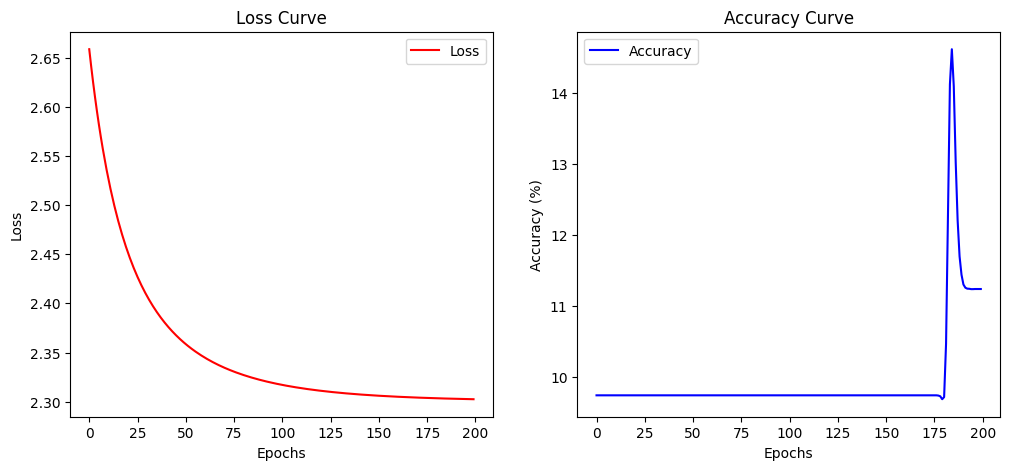

Test Accuracy: 11.35%


In [8]:
activations = ["sigmoid","sigmoid", "sigmoid", "sigmoid", "softmax"]
parameters, losses, gradient_magnitudes_history = train_neural_network(X_train, y_train, layer_sizes, activations, 200, 0.01)
accuracy, A = evaluate_model(X_test, y_test, parameters, activations)


Plotting activation histograms for hidden layers:


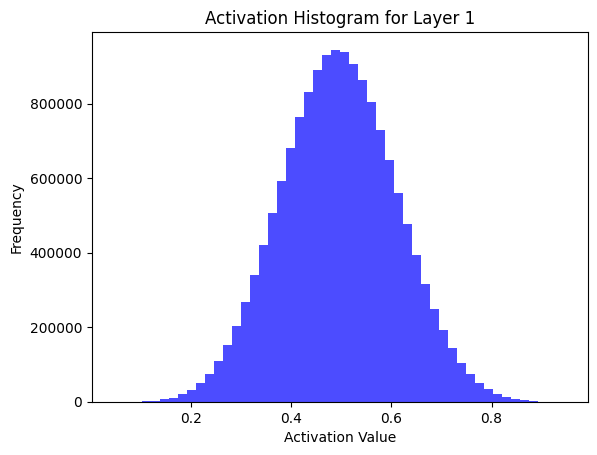

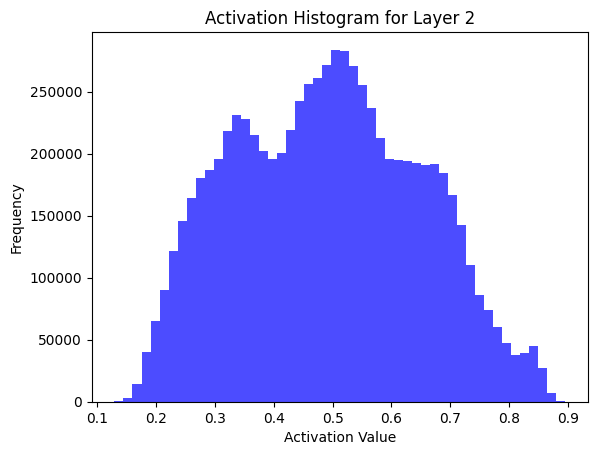

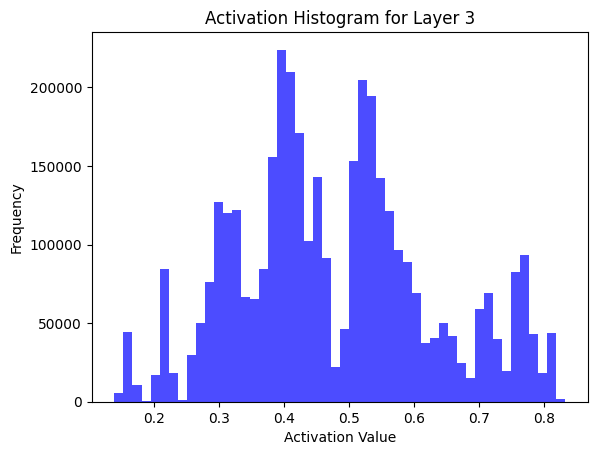

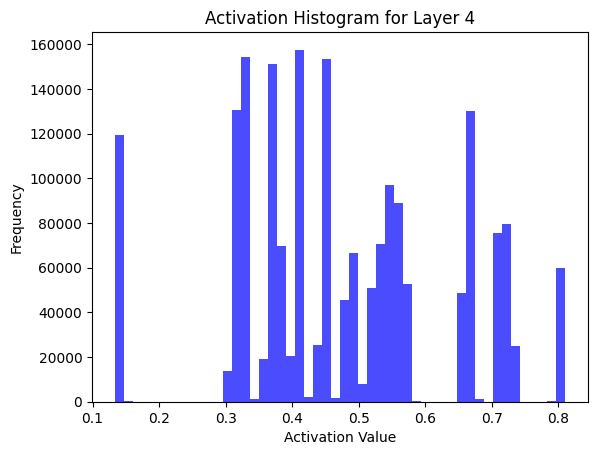

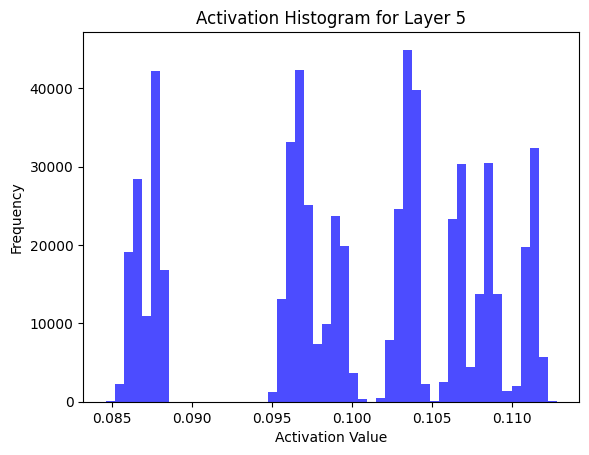

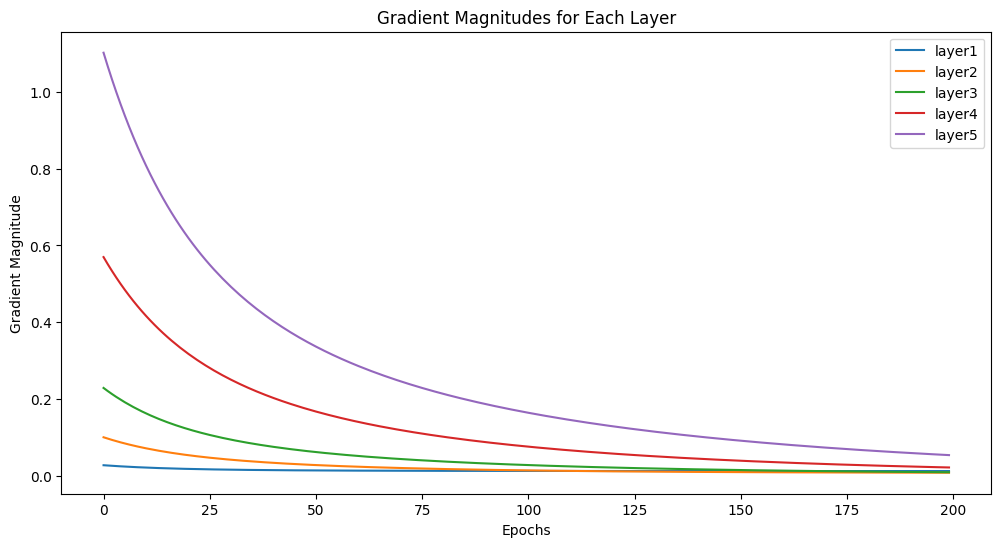

In [9]:
# Plot activation histograms
print("\nPlotting activation histograms for hidden layers:")
_, caches = forward_propagation(X_train, parameters, activations)  # Get latest activations

# Iterate through the caches list
for layer_idx, cache in enumerate(caches):
    # Extract the activation (A) from the cache dictionary
    if isinstance(cache, dict):  # Check if cache is a dictionary
        if "A" in cache:  # Check if "A" is the key for activations
            A = cache["A"]
        else:
            # If the key is different, inspect the cache to find the correct key
            print(f"Cache for layer {layer_idx + 1} does not contain key 'A'. Available keys: {cache.keys()}")
            continue
    else:
        print(f"Cache for layer {layer_idx + 1} is not a dictionary. Type: {type(cache)}")
        continue

    # Flatten the activation to plot the histogram
    A_flat = A.flatten()

    # Plot the histogram
    plt.figure()
    plt.hist(A_flat, bins=50, color='blue', alpha=0.7)
    plt.title(f'Activation Histogram for Layer {layer_idx + 1}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot gradient magnitudes for each layer
plt.figure(figsize=(12, 6))
for layer in gradient_magnitudes_history:
    plt.plot(range(200), gradient_magnitudes_history[layer], label=f"{layer}")
plt.xlabel("Epochs")
plt.ylabel("Gradient Magnitude")
plt.title("Gradient Magnitudes for Each Layer")
plt.legend()
plt.show()

Using ReLU for hidden layers and softmax for output layer.

Epoch 0, Loss: 2.3845, Accuracy: 9.27%
Epoch 10, Loss: 2.2565, Accuracy: 16.63%
Epoch 20, Loss: 2.1679, Accuracy: 28.18%
Epoch 30, Loss: 2.0900, Accuracy: 35.61%
Epoch 40, Loss: 2.0132, Accuracy: 39.98%
Epoch 50, Loss: 1.9346, Accuracy: 42.53%
Epoch 60, Loss: 1.8549, Accuracy: 44.48%
Epoch 70, Loss: 1.7745, Accuracy: 46.40%
Epoch 80, Loss: 1.6925, Accuracy: 48.82%
Epoch 90, Loss: 1.6082, Accuracy: 51.98%
Epoch 100, Loss: 1.5223, Accuracy: 55.71%
Epoch 110, Loss: 1.4360, Accuracy: 59.34%
Epoch 120, Loss: 1.3504, Accuracy: 62.79%
Epoch 130, Loss: 1.2670, Accuracy: 66.10%
Epoch 140, Loss: 1.1880, Accuracy: 69.26%
Epoch 150, Loss: 1.1146, Accuracy: 72.18%
Epoch 160, Loss: 1.0477, Accuracy: 74.32%
Epoch 170, Loss: 0.9877, Accuracy: 76.05%
Epoch 180, Loss: 0.9341, Accuracy: 77.37%
Epoch 190, Loss: 0.8864, Accuracy: 78.49%


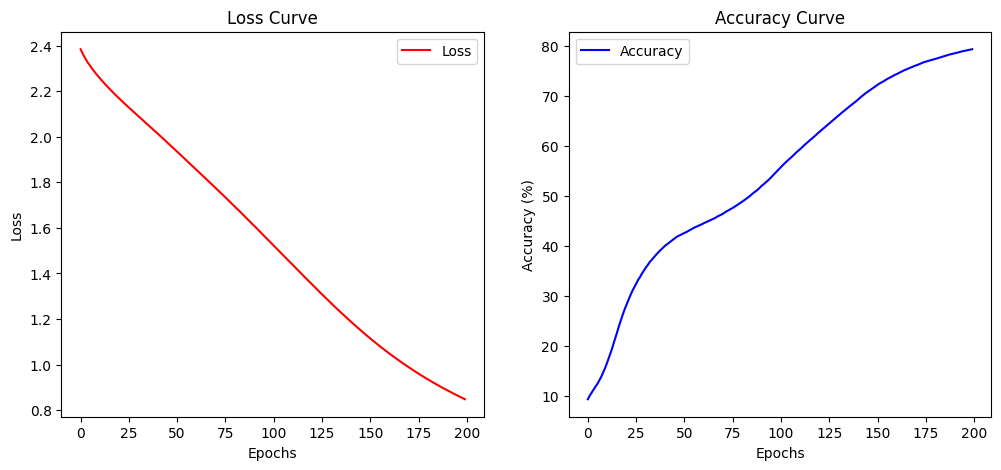

Test Accuracy: 79.70%

Plotting activation histograms for hidden layers:


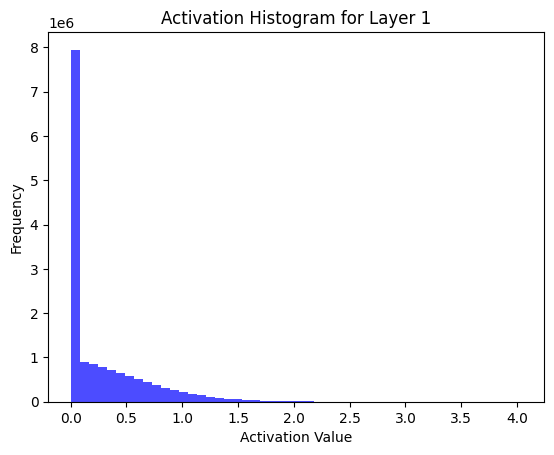

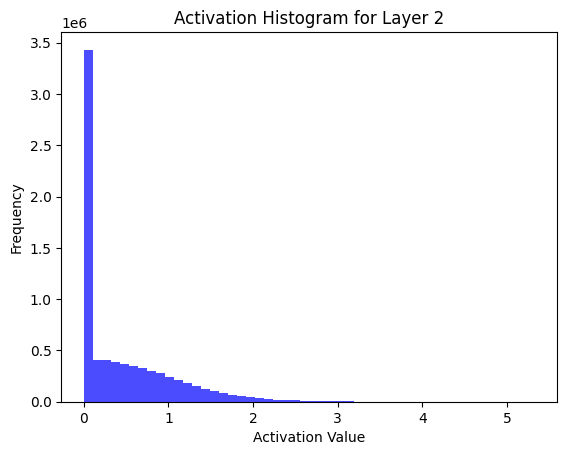

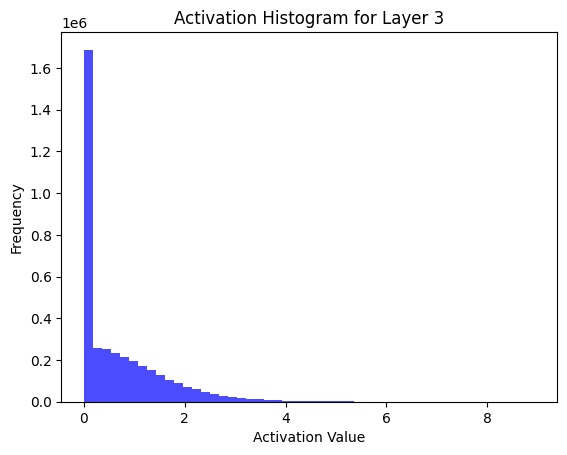

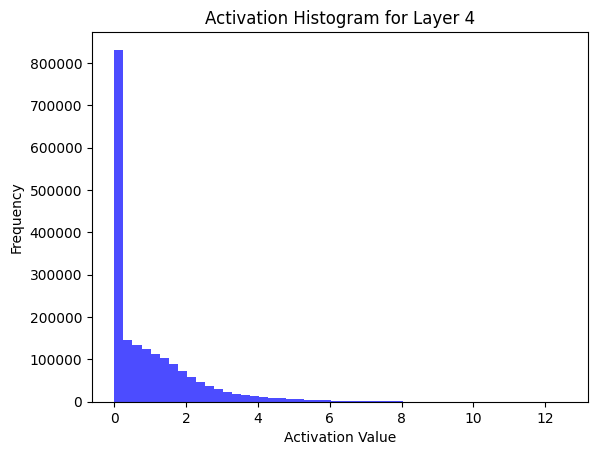

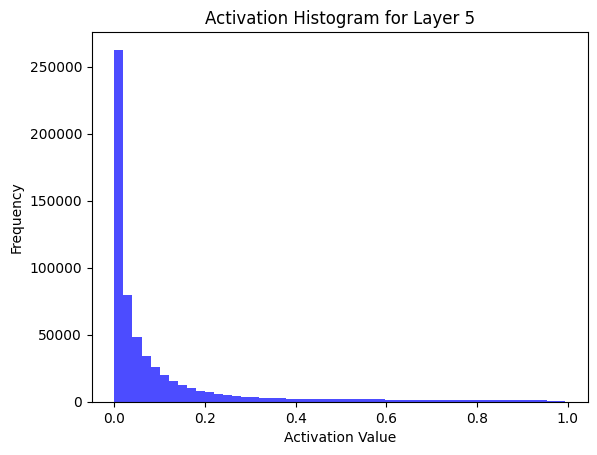

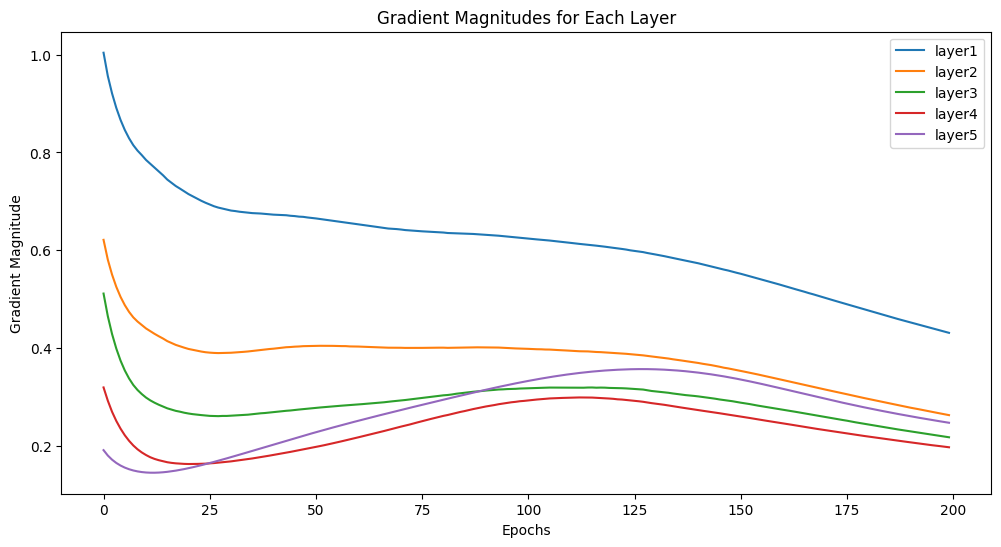

In [5]:
activations_relu = ["relu","relu", "relu", "relu", "softmax"]
parameters_relu, losses_relu, gradient_magnitudes_history_relu = train_neural_network(X_train, y_train, layer_sizes, activations_relu, 200, 0.01)
accuracy_relu, A_relu = evaluate_model(X_test, y_test, parameters_relu, activations_relu)


# Plot activation histograms
print("\nPlotting activation histograms for hidden layers:")
_, caches = forward_propagation(X_train, parameters_relu, activations_relu)  # Get latest activations

# Iterate through the caches list
for layer_idx, cache in enumerate(caches):
    # Extract the activation (A) from the cache dictionary
    if isinstance(cache, dict):  # Check if cache is a dictionary
        if "A" in cache:  # Check if "A" is the key for activations
            A = cache["A"]
        else:
            # If the key is different, inspect the cache to find the correct key
            print(f"Cache for layer {layer_idx + 1} does not contain key 'A'. Available keys: {cache.keys()}")
            continue
    else:
        print(f"Cache for layer {layer_idx + 1} is not a dictionary. Type: {type(cache)}")
        continue

    # Flatten the activation to plot the histogram
    A_flat = A.flatten()

    # Plot the histogram
    plt.figure()
    plt.hist(A_flat, bins=50, color='blue', alpha=0.7)
    plt.title(f'Activation Histogram for Layer {layer_idx + 1}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot gradient magnitudes for each layer
plt.figure(figsize=(12, 6))
for layer in gradient_magnitudes_history_relu:
    plt.plot(range(200), gradient_magnitudes_history_relu[layer], label=f"{layer}")
plt.xlabel("Epochs")
plt.ylabel("Gradient Magnitude")
plt.title("Gradient Magnitudes for Each Layer")
plt.legend()
plt.show()

Epoch 0, Loss: 2.4266, Accuracy: 10.38%
Epoch 10, Loss: 1.9417, Accuracy: 36.39%
Epoch 20, Loss: 1.6535, Accuracy: 54.37%
Epoch 30, Loss: 1.4587, Accuracy: 62.57%
Epoch 40, Loss: 1.3182, Accuracy: 67.30%
Epoch 50, Loss: 1.2119, Accuracy: 70.60%
Epoch 60, Loss: 1.1285, Accuracy: 73.23%
Epoch 70, Loss: 1.0612, Accuracy: 75.06%
Epoch 80, Loss: 1.0055, Accuracy: 76.58%
Epoch 90, Loss: 0.9586, Accuracy: 77.82%
Epoch 100, Loss: 0.9185, Accuracy: 78.82%
Epoch 110, Loss: 0.8836, Accuracy: 79.62%
Epoch 120, Loss: 0.8530, Accuracy: 80.34%
Epoch 130, Loss: 0.8258, Accuracy: 80.92%
Epoch 140, Loss: 0.8014, Accuracy: 81.51%
Epoch 150, Loss: 0.7794, Accuracy: 82.00%
Epoch 160, Loss: 0.7594, Accuracy: 82.44%
Epoch 170, Loss: 0.7410, Accuracy: 82.81%
Epoch 180, Loss: 0.7241, Accuracy: 83.17%
Epoch 190, Loss: 0.7085, Accuracy: 83.47%


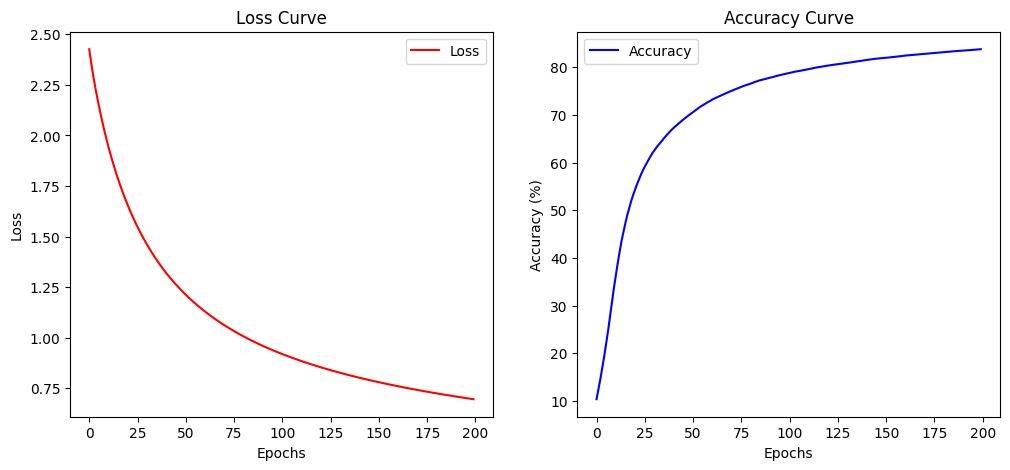

Test Accuracy: 84.65%

Plotting activation histograms for hidden layers:


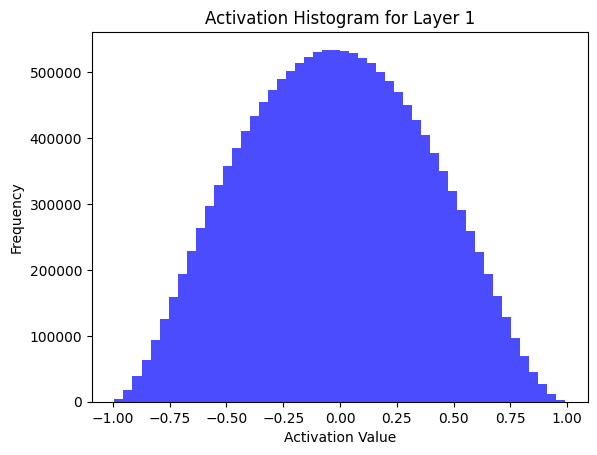

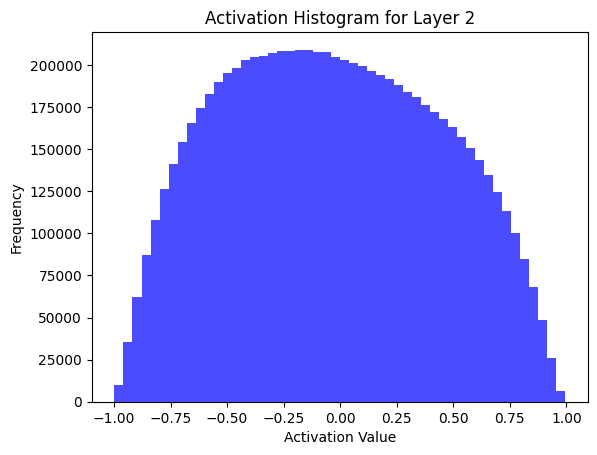

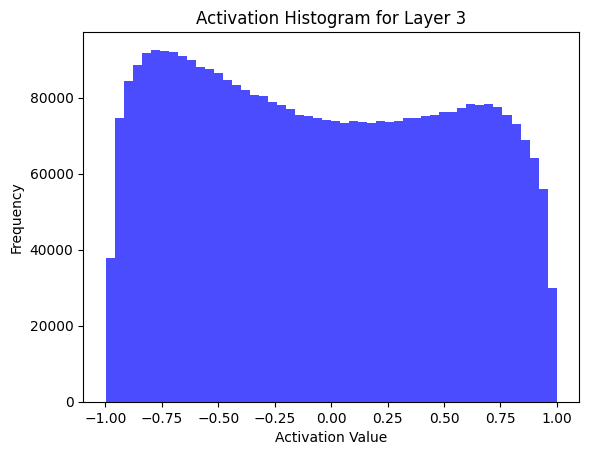

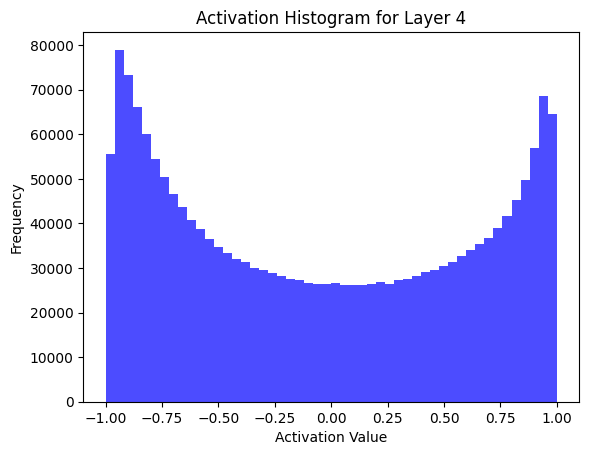

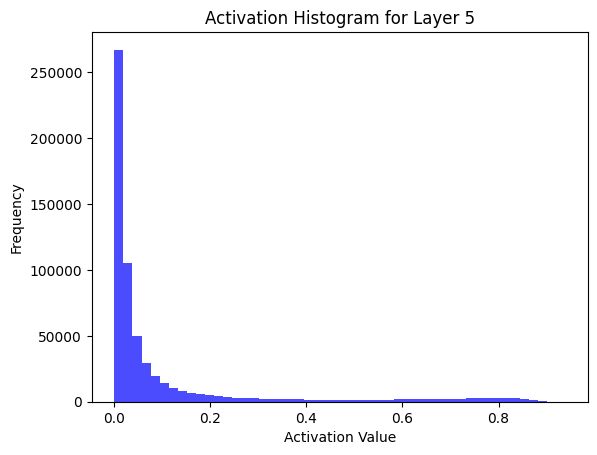

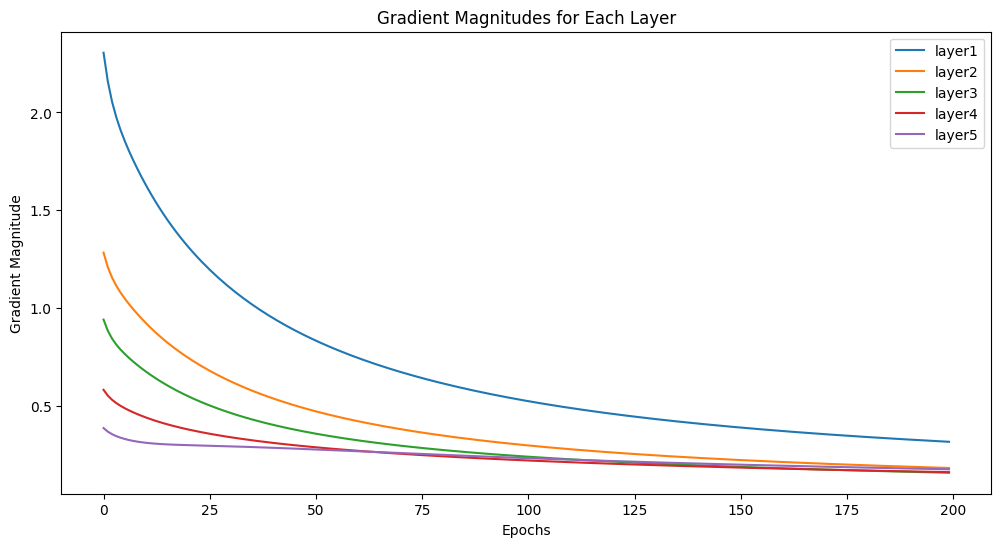

In [6]:
activations_tanh = ["tanh","tanh", "tanh", "tanh", "softmax"]
parameters_tanh, losses_tanh, gradient_magnitudes_history_tanh = train_neural_network(X_train, y_train, layer_sizes, activations_tanh, 200, 0.01)
accuracy_tanh, A_tanh = evaluate_model(X_test, y_test, parameters_tanh, activations_tanh)


# Plot activation histograms
print("\nPlotting activation histograms for hidden layers:")
_, caches = forward_propagation(X_train, parameters_tanh, activations_tanh)  # Get latest activations

# Iterate through the caches list
for layer_idx, cache in enumerate(caches):
    # Extract the activation (A) from the cache dictionary
    if isinstance(cache, dict):  # Check if cache is a dictionary
        if "A" in cache:  # Check if "A" is the key for activations
            A = cache["A"]
        else:
            # If the key is different, inspect the cache to find the correct key
            print(f"Cache for layer {layer_idx + 1} does not contain key 'A'. Available keys: {cache.keys()}")
            continue
    else:
        print(f"Cache for layer {layer_idx + 1} is not a dictionary. Type: {type(cache)}")
        continue

    # Flatten the activation to plot the histogram
    A_flat = A.flatten()

    # Plot the histogram
    plt.figure()
    plt.hist(A_flat, bins=50, color='blue', alpha=0.7)
    plt.title(f'Activation Histogram for Layer {layer_idx + 1}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot gradient magnitudes for each layer
plt.figure(figsize=(12, 6))
for layer in gradient_magnitudes_history_tanh:
    plt.plot(range(200), gradient_magnitudes_history_tanh[layer], label=f"{layer}")
plt.xlabel("Epochs")
plt.ylabel("Gradient Magnitude")
plt.title("Gradient Magnitudes for Each Layer")
plt.legend()
plt.show()

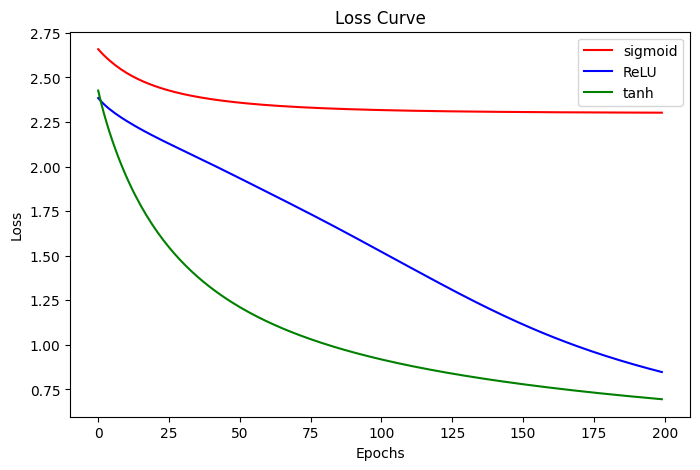

In [10]:
# Loss curves
plt.figure(figsize=(8,5))

plt.plot(range(200), losses, label="sigmoid", color="red")
plt.plot(range(200), losses_relu, label="ReLU", color="blue")
plt.plot(range(200), losses_tanh, label="tanh", color="green")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()